## Observations and Insights 

<u> Observation 1 </u>  
Looking at the boxplot for the four drug regimens (Capomulin, Ramicane, Infubinol, and Ceftamin), it appears that the drug regimen for Capomulin and Ramicane were equally successful at minimizing the tumor size compared to Infubinol and Ceftamin.  

<u> Observation 2  </u>
Looking at the Capomulin treatment, the Pearson Correlation Coefficient was 0.88, which shows a fairly strong positive correlation between the mouse weight and the tumor volume; the heavvier the mouse, the larger the tumor.  

<u> Observation 3  </u>
When looking at the summary statistics, the Capomulin and Ramicane distributions are narrower, as seen in the lower variance and standard error, compared to the other drug regimens.  This could be a sign of increased repeatability in results with the Capomulin and Ramicane drug regimens.  

In [1]:
# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sem
import numpy as np
from scipy.stats import linregress

## Import and Prepare Dataset

In [2]:
# Import the data files and check the data for any mouse ID that may have duplicate timepoints 
# and remove any data associated with that mouse ID.

# Define the paths of the mouse data and study results
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
combined_df = pd.merge(mouse_metadata, study_results, how='outer', on='Mouse ID')

# Display the data table for preview
combined_df.head(5)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [3]:
# Checking the number of lines and the number of mice in the original dataset.
print(f"The number of lines is {len(combined_df)}.")
print(f"The number of unique mice in the study is {combined_df['Mouse ID'].nunique()}.")

The number of lines is 1893.
The number of unique mice in the study is 249.


In [4]:
# Identify if there was data entry errors where the same mouse ID has multiple entries for the same timepoint.

# Create a dataframe to perform the datacheck using the combined data
df_duplicate_check = combined_df

# Convert the timepoint data to dtype = string to concatenate with the mouse ID
df_duplicate_check = df_duplicate_check.astype(str)

# Create a column in the dataframe of the concatenation between mouse ID and timepoint
df_duplicate_check['Concatenate'] = df_duplicate_check['Mouse ID'] + df_duplicate_check['Timepoint']
df_duplicate_check.head(1)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites,Concatenate
0,k403,Ramicane,Male,21,16,0,45.0,0,k4030


In [5]:
# Iterate through the rows in the combined dataframe to find duplicate lines where mouse ID and timepoint are the same
# Set some initial values
c = 0
check = []
col1 = df_duplicate_check.columns.get_loc('Concatenate')
col2 = df_duplicate_check.columns.get_loc('Mouse ID')
length = len(df_duplicate_check)

# Iterate through the rows in the dataframe
for i, row in df_duplicate_check.iterrows():
    
    # Check to see if the row being reviewed is the last row.  If so, break before error.
    if c == length-1:
        break
    
    # Check to see if the mouse ID / timepoint are duplicated in the row below in the datafraame
    elif df_duplicate_check.iloc[i, col1] == df_duplicate_check.iloc[i+1, col1]:
        
        # If there is a duplicate datapoint, record the mouse ID of the duplicate row
        check.append(df_duplicate_check.iloc[i, col2])
    
    # Counter to determine if we are at the bottom of the list.  
    # The program will error if it tries to check a row below that does not exist.
    c = c + 1

# Create a dataframe with the mouse ID's and all associated timepoints that have duplicate timepoints added
duplicate_mouse_all_lines = combined_df[combined_df['Mouse ID'].isin(np.unique(check))]
duplicate_mouse_all_lines

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [6]:
# Drop the rows for all data associated with the mouse ID with duplicated timepoints

# Determine the index values for the lines to be dropped
idx = duplicate_mouse_all_lines.index

# Define the clean dataframe using the original merged dataframe as a baseline
clean_df = combined_df

# Iterate through the index values to drop the lines in the clean dataframe
for i in idx:
    clean_df = clean_df.drop(combined_df.index[i])

# Print the new length of the clean dataframe and the number of unique mouse ID's to be analyzed
# This should show a drop in total rows and mouse ID based on the duplicates found
print(f"The number of lines is {len(clean_df)}.")
print(f"The number of unique mice in the study is {clean_df['Mouse ID'].nunique()}.")

The number of lines is 1880.
The number of unique mice in the study is 248.


## Summary Statistics

In [7]:
# Calculate the mean, median, variance, standard deviation and standard error of the tumor volume for each drug regimen
# Group the data by Drug Regimen
drug_group = clean_df.groupby("Drug Regimen")

# Calculate the mean of the tumor volume and store into a variable
drug_mean = drug_group['Tumor Volume (mm3)'].mean()

# Calculate the median of the tumor volume and store into a variable
drug_median = drug_group['Tumor Volume (mm3)'].median()

# Calculate the variance of the tumor volume and store into a variable
drug_var = drug_group['Tumor Volume (mm3)'].var()

# Calculate the standard deviation of the tumor volume and store into a variable
drug_stdev = drug_group['Tumor Volume (mm3)'].std()

# Calculate the standard error of the tumor volume and store into a variable
drug_sem = drug_group['Tumor Volume (mm3)'].sem()

In [8]:
# Generate a summary statistics table with the mean, median, variance, standard deviation and standard error for each drug regimen
summary_stats = pd.DataFrame({"Mean": drug_mean,
                                      "Median": drug_median,
                                      "Variance": drug_var,
                                      "Standard Deviation": drug_stdev,
                                      "Standard Error": drug_sem
                                     })
summary_stats

,Mean,Median,Variance,Standard Deviation,Standard Error
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [9]:
# Using the aggregation method, produce the same summary statistics in a single line
summary_stats_agg = drug_group.agg({"Tumor Volume (mm3)": ['mean', 'median', 'var', 'std', 'sem']})
summary_stats_agg

Tumor Volume (mm3)                                          
                           mean     median        var       std       sem
Drug Regimen                                                             
Capomulin             40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin              52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol             52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril              55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol              54.331565  52.509285  66.173479  8.134708  0.596466
Placebo               54.033581  52.288934  61.168083  7.821003  0.581331
Propriva              52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane              40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn              54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol             53.236507  51.818479  48.533355  6.966589  0.516398

## Bar and Pie Charts

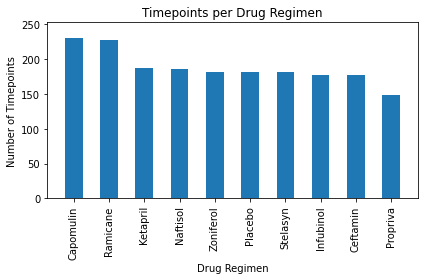

In [10]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.
# First create a DataFrame showing the number of timepoints for each drug regimen
drug_points = pd.value_counts(clean_df['Drug Regimen'])

# Create a bar chart using Pandas Plot
drug_points.plot(kind="bar")
plt.title("Timepoints per Drug Regimen")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Timepoints")
plt.xlim(-0.75, len(drug_points)-.25)
plt.ylim(0, max(drug_points)*1.10)
plt.tight_layout()
plt.show()

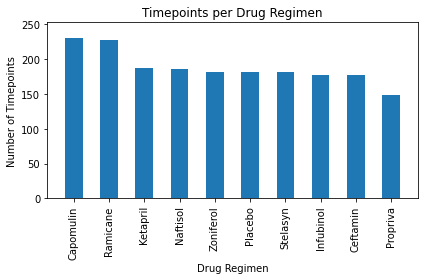

In [11]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.
# First define the x-axis and y-axis data sets
x_axis = clean_df['Drug Regimen'].value_counts().index
y_axis = clean_df['Drug Regimen'].value_counts()

# Plot the bar chart using Matplotlib
plt.bar(x_axis, y_axis, align="center", width=0.5)
plt.xticks(rotation=90)
plt.title("Timepoints per Drug Regimen")
plt.xlabel("Drug Regimen")
plt.ylabel("Number of Timepoints")
plt.xlim(-0.75, len(drug_points)-.25)
plt.ylim(0, max(drug_points)*1.10)
plt.tight_layout()
plt.show()

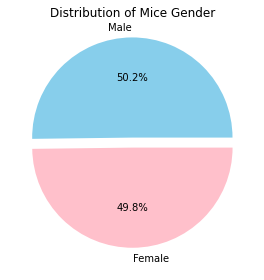

In [12]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas
# First create a DataFrame showing the number of male and female mice in the drug study
gender_count = pd.value_counts(mouse_metadata['Sex'])

# Create a pie chart using Pandas Plot
explode = (0.1,0 )
color = ['skyblue', 'pink']
gender_count.plot(kind="pie", explode=explode, colors=color, autopct="%1.1f%%")
plt.title("Distribution of Mice Gender")
plt.ylabel('')
plt.tight_layout()
plt.show()

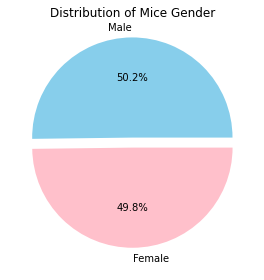

In [13]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
# First define the data set and labels
labels = mouse_metadata['Sex'].value_counts().index
data = mouse_metadata['Sex'].value_counts()

# Plot the bar chart using Matplotlib
explode = (0.1, 0)
color = ['skyblue', 'pink']
plt.pie(data, labels=labels, explode=explode, colors=color, autopct="%1.1f%%")
plt.title("Distribution of Mice Gender")
plt.tight_layout()
plt.show()

## Quartiles, Outliers and Boxplots

In [14]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
mouse_max_timepoint = clean_df.groupby(['Mouse ID']).max('Timepoint')
mouse_max_timepoint = mouse_max_timepoint.drop(columns=['Age_months', 'Weight (g)', 'Tumor Volume (mm3)', 'Metastatic Sites'])
mouse_max_timepoint = mouse_max_timepoint.reset_index()

In [15]:
# Merge the tumor volume data for the max timepoint for each mouse
tumor_size = mouse_max_timepoint.merge(clean_df, left_on=['Mouse ID', 'Timepoint'], right_on=['Mouse ID', 'Timepoint'], how='left')
tumor_size = tumor_size.drop(columns=['Sex', 'Age_months', 'Weight (g)', 'Metastatic Sites'])

In [16]:
# Put the treatments for focus into a list
filter_list = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

# Filter the full DataFrame for only those rows that contain the drug treatment for focus
tumor_size_filter = tumor_size[tumor_size['Drug Regimen'].isin(filter_list)]

In [17]:
# Setup variable lists for the four drugs of interest
capomulin = []
ramicane = []
infubinol = []
ceftamin = []

# Pull index numbers for the columns for Drug Regimen and Tumor Volume
col_index_x = tumor_size_filter.columns.get_loc('Drug Regimen')
col_index_y = tumor_size_filter.columns.get_loc('Tumor Volume (mm3)')

# Iterate through the rows of data, find which drug regimen was used, and add the tumor volume to the list for that drug regimen
for i, rows in tumor_size_filter.iterrows():
    if 'Capomulin' in rows[col_index_x]:
        capomulin.append(rows[col_index_y])
    elif 'Ramicane' in rows[col_index_x]:
        ramicane.append(rows[col_index_y])
    elif 'Infubinol' in rows[col_index_x]:
        infubinol.append(rows[col_index_y])
    elif 'Ceftamin' in rows[col_index_x]:
        ceftamin.append(rows[col_index_y])

In [18]:
# Define a subroutine that will calculate the quartiles 
def quart(list):
    quart_df = pd.DataFrame(list)
    quartiles = quart_df[0].quantile([.25, .5, .75])

    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]

    iqr = upperq - lowerq
    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    
    print("")
    print(f'The lower quartile is {"{:.3f}".format(lowerq)}.')
    print(f'The upper quartile is {"{:,.3f}".format(upperq)}.')
    print(f'The IQR is {"{:,.3f}".format(iqr)}.')
    print(f'The lower bound is {"{:,.3f}".format(lower_bound)}.')
    print(f'The upper bound is {"{:,.3f}".format(upper_bound)}.')
    
    if any(t < lower_bound for t in list):
        return('*** There are potential outliers - data points BELOW lower limit. ***')
    elif any(t > upper_bound for t in list):
        return('*** There are potential outliers - data points ABOVE upper limit. ***')
    else:
        return('All data points are inside of the lower and upper limits.')

# Using the subroutine, review each of the drug regimens to determine if there are any outliers in the datasets.
print(f"Results for Capomulin : {quart(capomulin)}")
print(f"Results for Ramicane : {quart(ramicane)}")
print(f"Results for Infubinol : {quart(infubinol)}")
print(f"Results for Ceftamin : {quart(ceftamin)}")


The lower quartile is 32.377.
The upper quartile is 40.159.
The IQR is 7.782.
The lower bound is 20.705.
The upper bound is 51.832.
Results for Capomulin : All data points are inside of the lower and upper limits.

The lower quartile is 31.560.
The upper quartile is 40.659.
The IQR is 9.099.
The lower bound is 17.913.
The upper bound is 54.307.
Results for Ramicane : All data points are inside of the lower and upper limits.

The lower quartile is 54.049.
The upper quartile is 65.526.
The IQR is 11.477.
The lower bound is 36.833.
The upper bound is 82.741.
Results for Infubinol : *** There are potential outliers - data points BELOW lower limit. ***

The lower quartile is 48.722.
The upper quartile is 64.300.
The IQR is 15.578.
The lower bound is 25.355.
The upper bound is 87.666.
Results for Ceftamin : All data points are inside of the lower and upper limits.


C:\Users\jcbat\AppData\Local\Temp/ipykernel_63632/955070563.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(filter_list)


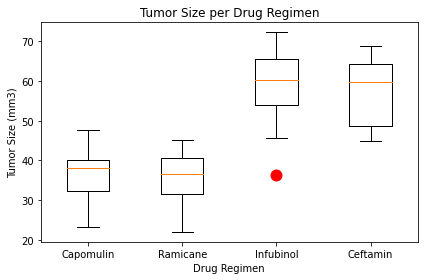

In [19]:
# Create a box plots showing the four drug regimens

# Combine the data for the different drug regimens into a single array
data = [capomulin, ramicane, infubinol, ceftamin]

# Dictionary with the formatting for outliers in the boxplot
flierprops = dict(marker='o', markerfacecolor='red', markersize=12, markeredgecolor='none')

# Create the boxplot graph
fig1, ax1 = plt.subplots()
ax1.set_title('Tumor Size per Drug Regimen')
ax1.set_ylabel('Tumor Size (mm3)')
ax1.set_xlabel('Drug Regimen')
ax1.set_xticklabels(filter_list)
ax1.boxplot(data, flierprops=flierprops)
plt.tight_layout()

## Line and Scatter Plots

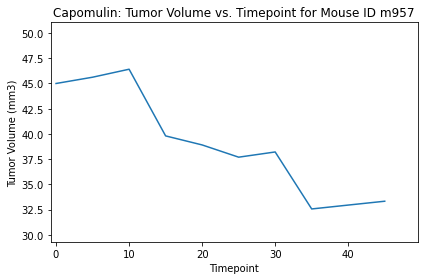

In [20]:
# Select a mouse that was treated with Capomulin and generate a line plot of tumor volume vs. time point for that mouse

# Filter clean dataframe on just Capomulin drug regimen
capomulin_df = clean_df[clean_df['Drug Regimen'] == 'Capomulin']

# Select a sample of one from the capomulin dataframe
sample_df = capomulin_df.sample(1)

# Capture the Mouse ID from that sample line
sample_mouse_id = sample_df.iloc[0, 0]

# Using the Mouse ID, filter the original dataset to get all of the timepoints of that mouse ID.
# Sort the dataframe in ascending timepoint (earliest to latest)
single_mouse_df = clean_df[clean_df['Mouse ID'] == sample_mouse_id].sort_values('Timepoint', ascending=True)

# Plot a line graph of the Tumor Volume versus Timepoint for the selected Mouse ID
plt.plot(single_mouse_df['Timepoint'], single_mouse_df['Tumor Volume (mm3)'])
plt.title(f'Capomulin: Tumor Volume vs. Timepoint for Mouse ID {sample_mouse_id}')
plt.xlabel('Timepoint')
plt.ylabel('Tumor Volume (mm3)')
plt.xlim(-.75,single_mouse_df['Timepoint'].max()*1.10)
plt.ylim(single_mouse_df['Tumor Volume (mm3)'].min()*0.90, single_mouse_df['Tumor Volume (mm3)'].max()*1.10)
plt.tight_layout()
plt.show()

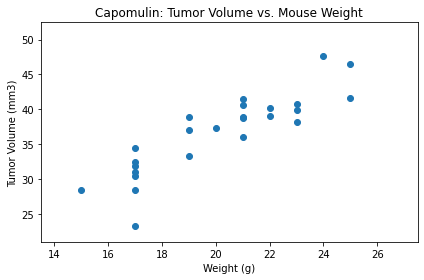

In [21]:
# Generate a scatter plot of tumor volume versus mouse weight for the Capomulin treatment regimen

# Use the dataframe created above for the tumor size for the last timepoint
# Filter that dataframe on the Capomulin treatment
cap_tum_vol = tumor_size[tumor_size['Drug Regimen'] == 'Capomulin']

# Merge the mouse weight to this dataframe using mouse ID.
cap_tum_vol_wt = pd.merge(cap_tum_vol, mouse_metadata[['Mouse ID', 'Weight (g)']], how='left', on='Mouse ID')

# Generate the scatter plot
plt.scatter(cap_tum_vol_wt['Weight (g)'], cap_tum_vol_wt['Tumor Volume (mm3)'])
plt.title('Capomulin: Tumor Volume vs. Mouse Weight')
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')
plt.xlim(cap_tum_vol_wt['Weight (g)'].min()*0.90, cap_tum_vol_wt['Weight (g)'].max()*1.10)
plt.ylim(cap_tum_vol_wt['Tumor Volume (mm3)'].min()*0.90, cap_tum_vol_wt['Tumor Volume (mm3)'].max()*1.10)
plt.tight_layout()
plt.show()

## Correlation and Regression

The Pearson Correlation Coefficient between mouse weight and tumor volume is 0.88



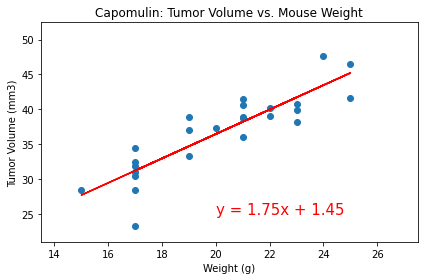

In [22]:
# Calculate the correlation of coefficient and linear regression model between mouse weight and average tumor volume
# for the Capomulin treatment.  Plot the linear regression model on top of the previous scatter plot.  

# Calculate the Pearson correlation coefficient.  
# Create variables for the two lists of data to compare: weight and tumor volume
weight = cap_tum_vol_wt.loc[:,'Weight (g)']
size = cap_tum_vol_wt.loc[:, 'Tumor Volume (mm3)']
correlation = sem.pearsonr(weight,size)
print(f"The Pearson Correlation Coefficient between mouse weight and tumor volume is {round(correlation[0],2)}")
print("")

# Add the linear regression model and equation to the scatter plot
# Calculate the liner regression equation
x_values = weight      
y_values = size    
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)      
regress_values = x_values * slope + intercept    
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))    

# Plot the linear regression line on the scatter plot from above
plt.scatter(cap_tum_vol_wt['Weight (g)'], cap_tum_vol_wt['Tumor Volume (mm3)'])
plt.title('Capomulin: Tumor Volume vs. Mouse Weight')
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')
plt.xlim(cap_tum_vol_wt['Weight (g)'].min()*0.90, cap_tum_vol_wt['Weight (g)'].max()*1.10)
plt.ylim(cap_tum_vol_wt['Tumor Volume (mm3)'].min()*0.90, cap_tum_vol_wt['Tumor Volume (mm3)'].max()*1.10)
plt.plot(x_values,regress_values,"r-")               # plot regression line
plt.annotate(line_eq,(20,25),fontsize=15,color="red") 
plt.tight_layout()
plt.show()